In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal, Independent

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons

torch.manual_seed(1)

# Flow Models

Flow models are generative models with map a latent distribution $p(z)$ to an observed distribution $p(x)$ through a function $f(x)$. 

This is very similar to what a probabilistic graphical model does. However, the main difference relies on $f()$ being a bijection. This can be easily achieved through these two restrictions:

* Both $z$ and $x$ have same dimensionality.
* $f()$ is invertible

The idea is define an invertible mapping $f(x)$ such that:

$$
\begin{align*}
z = f(x)\\
x = f^{-1}(z)
\end{align*}
$$

Alongside a prior probability over $z$, $p(z)$.


Under this setting, we can write the probability $p(x)$ as:

$$
\begin{align*}
p(x) &= p(z)\mid\det \frac{\text{d}f(x)}{\text{d} x}\mid\\
&=p(f(x))\mid\det \frac{\text{d}f(x)}{\text{d} x}\mid
\end{align*}
$$

There is a theorem out there which allow us to write the above formula as:

$$
\begin{align*}
p(x) &= p(z)\mid\det \frac{\text{d}f^{-1}(z)}{\text{d} z}\mid^{-1}
\end{align*}
$$

Which of the directions to use depends strongly on the application (variational inference, generative modelling) and whether the direct or inverse mapping is easy to invert. Also one can also find the direct mapping as $x = f(z)$ and so we need to plug in the change in the equations above.

One appealing property of such invertible transofrmations is that we can construct arbitrary complex $f()$ by a composition of elementary invertible functions such that:

$$
f(x) = f_1(x)\circ f_2 \circ \dots \circ f_K
$$


If this is the case, then we have:

$$
p(x) = p(f(x))\prod^{K}_{k=1}\mid\det \frac{\text{d}f_k(x_{k-1})}{\text{d} x_{k-1}}\mid
$$

where $\mid \det \frac{\text{d}f_k(x_{k-1})}{x_{k-1}}\mid$ is the absolute value of the determinant of the Jacobian of the transformation $f_k$. Alternative we have:

$$
p(x) = p(f(x))\prod^{K}_{k=1}\mid\det \frac{\text{d}f^{-1}_k(x_{k})}{\text{d} x_{k}}\mid^{-1}
$$


#### Training of such models

Since $p(x)$ has a explicit formula, we can maximize the log probability over some dataset, such that:

$$
\begin{align*}
\log \prod^N_{n=1} p(x) &= \sum^N_{n=1} \log p(f(x^n))\prod^{K}_{k=1}\mid\det \frac{\text{d}f_k(x^n_{k-1})}{\text{d} x^n_{k-1}}\mid\\
&= \sum^N_{n=1}\log p(f(x^n)) + \sum^N_{n=1}\sum^{K}_{k=1}\log \mid\det \frac{\text{d}f_k(x^n_{k-1})}{\text{d} x^n_{k-1}}\mid
\end{align*}
$$

Thus, the main bottleneck is computing the determinant of the Jacobian, which typically requires a cubic cost. However, if we can construct transformations such that the Jacobian is diagonal, then the log determinant is just the sum of the diagonals. Well, flow generative modelling is concerned exactly with that. Note that diagonal Jacobians are not of interest since that would require that we are only able to model the distribution over $x$ by changing the marginals from $p(z)$. In other words, the dependencies are exactly modelled by the same copula as the based sitribution $p(z)$.

On the other hand, when the determinant of the Jacobian is $1$, this transformations are known as volume preserving, which means that a region of density in $z$ is exactly mapped to a region of density in $x$. This implies that the transformation $f()$ cannot contract nor expand the region over which some mass of probability is assigned.

When the transformation is volume preserving we just need to optimize:

$$
\begin{align*}
\log \prod^N_{n=1} p(x) &= \sum^N_{n=1} \log p(f(x^n))\prod^{K}_{k=1}\mid\det \frac{\text{d}f_k(x^n_{k-1})}{\text{d} x^n_{k-1}}\mid\\
&= \sum^N_{n=1}\log p(f(x^n)) 
\end{align*}
$$

# NICE

## Volume Preserving Version

https://arxiv.org/pdf/1410.8516

Non-linear independent component estimation is a way of constructing $f()$ such that we can start from a simple prior independent latent distribution and use $f()$ to construct joint dependent distributions. 

This results in a lower-triangular Jacobian, which is volume preserving.

Assume we have data with dimensionality $D$, i.e. $x\in\mathbb{R}^D$. Assume we partition $x$ the first $D/2$ dimensions and the rest such that:

$$
\begin{align*}
x_a = x_{1\dots D/2}\\
x_b = x_{D/2+1\dots D}
\end{align*}
$$

Each of the steps in $f()$ is constructed either by:

$$
\begin{align*}
y_a &= x_a\\
y_b &= x_b + \text{NNET}(x_a)
\end{align*}
$$

or

$$
\begin{align*}
y_a &= x_a + \text{NNET}(x_b)\\
y_b &= x_b
\end{align*}
$$

such that all dimensions influence all dimensions, otherwise some of the dimensions will just be copies from the input. Each step in this transformation has an inverse given by:

$$
\begin{align*}
x_a &= y_a\\
x_b &= y_b - \text{NNET}(x_a)
\end{align*}
$$

The Jacobian of the transformation is given by:

$$
\begin{align*}
\begin{pmatrix}
\frac{\text{d} y_a}{\text{d} x_a} & \frac{\text{d}y_a}{\text{d}x_b}\\
\frac{\text{d}y_b}{\text{d} x_a} & \frac{\text{d}y_b}{\text{d}x_b}\\
\end{pmatrix}=
%
\begin{pmatrix}
{\bf I} & 0\\
\frac{\text{d}y_b}{\text{d} x_a} & {\bf I}\\
\end{pmatrix}
\end{align*}
$$

and so the transformation has unit Jacobian (product of diagonals).

## Non Volume Preserving Version

In the work, since the Jacobian of the affine copuling layer is 1, this implies that the flow cannot change the amount of assigned density between the latent and observed space. 

To overcome this limitation the authors append a final layer consisting on a diagonal matrix $S$ that scales the input. Such transformation is given by:

$$
{\bf y} ={\bf s^T I x}
$$

where $s$ is the vector containing the variance. The Jacobian of such transformation is given by:


$$
\begin{align*}
\begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \cdots & \frac{\partial y_1}{\partial x_D} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \cdots & \frac{\partial y_2}{\partial x_D} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial y_D}{\partial x_1} & \frac{\partial y_D}{\partial x_2} & \cdots & \frac{\partial y_D}{\partial x_D}
\end{pmatrix}=
%
\begin{pmatrix}
s_1 & 0 & \cdots & 0 \\
0 & s_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & s_D
\end{pmatrix}
\end{align*}
$$

In this case the log determinant of the Jacobian is given by the sum of the absolute values of the diagonal.

# Real Valued Non Volume Preserving Flow

https://arxiv.org/abs/1605.08803

This is the extension of the NICE work. In this case the coupling layers are defined as:

$$
\begin{align*}
x_a = x_{1\dots D/2}\\
x_b = x_{D/2+1\dots D}
\end{align*}
$$

Each of the steps in $f()$ is constructed either by:

$$
\begin{align*}
y_a &= x_a\\
y_b &= x_b e^{\text{NNET}_1(x_a)} + \text{NNET}_2(x_a)
\end{align*}
$$

$$
\begin{align*}
y_a &= x_a  e^{\text{NNET}_1(x_b)} + \text{NNET}_2(x_b)\\
y_b &= x_b
\end{align*}
$$

Each step in this transformation has an inverse given by:

$$
\begin{align*}
x_a &= y_a\\
x_b &= e^{-\text{NNET}_1(x_a)}(y_b - \text{NNET}_2(x_a))
\end{align*}
$$

The Jacobian of the transformation is given by:

$$
\begin{align*}
\begin{pmatrix}
\frac{\text{d} y_a}{\text{d} x_a} & \frac{\text{d}y_a}{\text{d}x_b}\\
\frac{\text{d}y_b}{\text{d} x_a} & \frac{\text{d}y_b}{\text{d}x_b}\\
\end{pmatrix}=
%
\begin{pmatrix}
{\bf I} & 0\\
\frac{\text{d}y_b}{\text{d} x_a} & \text{diag}(e^{\text{NNET}_1(x_a)})
\end{pmatrix}
\end{align*}
$$

This transformation is non-volume preserving as seen by the Jacobian. Since it is lower triangular, the Jacobian is the product of the diagonals. As such the log determinant Jacobian of this transformation is:

$$
\begin{align*}
\sum_{d=D/2+1}^{D} \log \exp\big(\text{NNET}_1(x_d)\big) \\
\sum_{d=D/2+1}^{D} \text{NNET}_1(x_d)
\end{align*}
$$


In [2]:
class CouplingLayer(nn.Module):
    def __init__(self, dim, hidden_dim, flip=False):
        super().__init__()

        self.dim = dim
        self.flip = flip

        # Partition
        self.d1 = dim // 2  

        # m(x) network
        self.m = nn.Sequential(
            nn.Linear(self.d1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim - self.d1)
        )

    def forward(self, x):
        """
        Forward transformation.
        """
        x1 = x[:, :self.d1]
        x2 = x[:, self.d1:]

        if not self.flip:
            y1 = x1
            y2 = x2 + self.m(x1)
        else:
            y1 = x1 + self.m(x2)
            y2 = x2

        return torch.cat([y1, y2], dim=1)

    def inverse(self, y):
        """
        Exact inverse transformation.
        """
        y1 = y[:, :self.d1]
        y2 = y[:, self.d1:]

        if not self.flip:
            x1 = y1
            x2 = y2 - self.m(y1)
        else:
            x1 = y1 - self.m(y2)
            x2 = y2

        return torch.cat([x1, x2], dim=1)

    def log_det_jacobian(self,x):
        return torch.zeros(x.size(0), device = x.device)


class CouplingLayerNVP(nn.Module):
    # https://arxiv.org/abs/1605.08803
    def __init__(self, dim, hidden_dim, flip=False):
        super().__init__()

        self.dim = dim
        self.flip = flip

        # Partition
        self.d1 = dim // 2  

        # scale factor for s()
        self.s_scale_factor = 1.5

        # t(x) and s(x) networks
        self.t = nn.Sequential(
            nn.Linear(self.d1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim - self.d1)
        )

        self.s = nn.Sequential(
            nn.Linear(self.d1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim - self.d1),
            nn.Tanh(),
        )

        ## Initialize flow to the 
        nn.init.zeros_(self.t[-1].weight)
        nn.init.zeros_(self.t[-1].bias)
        
        nn.init.zeros_(self.s[-2].weight)  # -2 porque el último es Tanh
        nn.init.zeros_(self.s[-2].bias)
        

    def forward(self, x):
        """
        Forward transformation.
        """
        x1 = x[:, :self.d1]
        x2 = x[:, self.d1:]

        if not self.flip:
            y1 = x1
            y2 = x2 * torch.exp(self.s(x1)*self.s_scale_factor) + self.t(x1)
        else:
            y1 = x1 * torch.exp(self.s(x2)*self.s_scale_factor) + self.t(x2)
            y2 = x2

        return torch.cat([y1, y2], dim=1)

    def inverse(self, y):
        """
        Exact inverse transformation.
        """
        y1 = y[:, :self.d1]
        y2 = y[:, self.d1:]

        if not self.flip:
            x1 = y1
            x2 = (y2 - self.t(x1))*torch.exp(-self.s(x1)*self.s_scale_factor)           
        else:
            x2 = y2
            x1 = (y1 - self.t(x2))*torch.exp(-self.s(x2)*self.s_scale_factor)  
            

        return torch.cat([x1, x2], dim=1)

    def log_det_jacobian(self,x):
        if not self.flip:
            x1 = x[:, :self.d1]
            log_det_jacobian = torch.sum(self.s(x1)*self.s_scale_factor, dim = 1)
        else:
            x2 = x[:, self.d1:]
            log_det_jacobian = torch.sum(self.s(x2)*self.s_scale_factor, dim = 1)
        return log_det_jacobian 

class DiagonalScalingMatrixLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.S = nn.Parameter(torch.ones(dim,))

    def forward(self, x):
        """
        Forward transformation.
        """
        return self.S * x

    def inverse(self, y):
        """
        Exact inverse transformation.
        """
        return 1/self.S * y

    def log_det_jacobian(self,x):
        log_det_jacobian = torch.sum(torch.log(torch.abs(self.S)))
        return log_det_jacobian.expand(x.size(0))

class _FlowModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def x_to_z(self, x):
        z = x
        for layer in self.layers:
            z = layer(z)
        return z

    def z_to_x(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

    def log_likelihood(self, x):
        """
        Compute log p(x) = log p(f(x)) + log|det J|

        It uses forward computation ie starts from x maps to z.
        Thus, each step in the Jacobian computation starts from x_{k-1}
        
        """
        z = x
        log_det_jacobian = torch.zeros(x.size(0), dtype = x.dtype)
        for layer in self.layers:
            ## call first log_det_jacobian since it receives x_{k-1}
            log_det_jacobian += layer.log_det_jacobian(z)
            z = layer(z)

        # Prior log-probability
        log_pz = self.prior.log_prob(z)

        return log_pz + log_det_jacobian

    def generate_sample(self, num_samples):
        """
        Sample from flow model
        """
        # draw a sample from p(z)
        z = self.prior.sample((num_samples,))

        # draw a sample through the mapping
        x = self.z_to_x(z)
        return x, z

    def inference(self, x):
        """
        Compute latent assignment z
        """
        # encode
        z = self.x_to_z(x)
        return z

class NICEVP(_FlowModel):
    """
    Volume Preserving NICE
    """
    def __init__(self, dim, hidden_dim, num_coupling_layers=4):
        super().__init__(dim)

        # Coupling layers with alternating flip
        layers = []
        for i in range(num_coupling_layers):
            flip = (i % 2 == 1)
            layers.append(CouplingLayer(dim, hidden_dim, flip=flip))
        self.layers = nn.ModuleList(layers)

        # Prior distribution
        self.prior = Independent(Normal(torch.zeros(dim), torch.ones(dim)), 1)


class NICE(NICEVP):
    """
    Non Volume Preserving NICE
    """
    def __init__(self, dim, hidden_dim, num_coupling_layers=4):
        super().__init__(dim = dim, hidden_dim=hidden_dim, num_coupling_layers = num_coupling_layers)
        
        # Coupling layers with alternating flip
        layers = []
        for i in range(num_coupling_layers):
            flip = (i % 2 == 1)
            layers.append(CouplingLayer(dim, hidden_dim, flip=flip))

        # add diagonal scaling
        layers.append(DiagonalScalingMatrixLayer(dim))

        ## list of coupling layers
        self.layers = nn.ModuleList(layers)

        # Prior distribution
        self.prior = Independent(Normal(torch.zeros(dim), torch.ones(dim)), 1)


class RealNVP(_FlowModel):
    """
    Volume Preserving NICE
    """
    def __init__(self, dim, hidden_dim, num_coupling_layers=4):
        super().__init__(dim)

        # Coupling layers with alternating flip
        layers = []
        for i in range(num_coupling_layers):
            flip = (i % 2 == 1)
            layers.append(CouplingLayerNVP(dim, hidden_dim, flip=flip))
        self.layers = nn.ModuleList(layers)

        # Prior distribution
        self.prior = Independent(Normal(torch.zeros(dim), torch.ones(dim)), 1)


### Generate Data

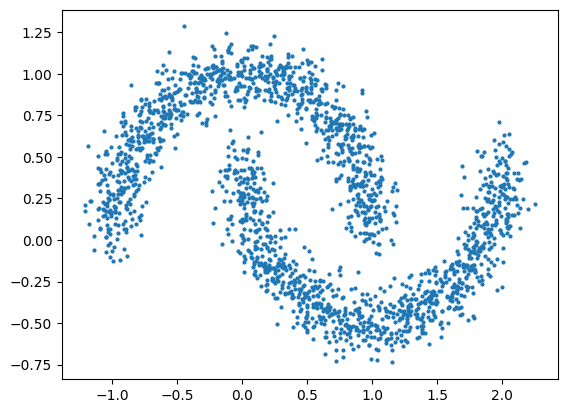

In [3]:
# -----------------------------
# Generar dataset Two Moons
# -----------------------------
X, _ = make_moons(n_samples=2000, noise=0.1, random_state=42)

plt.plot(X[:,0],X[:,1],'o', color = "C0", markersize = 2)

### Create torch tensor dataset

In [4]:
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)

batch_size = 2000
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Train Model Volume Preserving NICE

In [5]:
model = NICEVP(dim = 2, hidden_dim=128, num_coupling_layers = 6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 3000

for epoch in range(epochs):
    for x_tr, in dataloader:
        loss = -model.log_likelihood(x_tr).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {-loss.item():.4f}")

Epoch 100, Loss: -4384.5791
Epoch 200, Loss: -4315.1177
Epoch 300, Loss: -4267.2041
Epoch 400, Loss: -4198.3652
Epoch 500, Loss: -4136.8242
Epoch 600, Loss: -4107.5845
Epoch 700, Loss: -4079.5256
Epoch 800, Loss: -4063.0183
Epoch 900, Loss: -4053.5408
Epoch 1000, Loss: -4048.1025
Epoch 1100, Loss: -4045.5615
Epoch 1200, Loss: -4044.3958
Epoch 1300, Loss: -4043.8167
Epoch 1400, Loss: -4043.4790
Epoch 1500, Loss: -4043.2637
Epoch 1600, Loss: -4043.0591
Epoch 1700, Loss: -4042.8967
Epoch 1800, Loss: -4042.7256
Epoch 1900, Loss: -4042.5669
Epoch 2000, Loss: -4042.4053
Epoch 2100, Loss: -4042.2385
Epoch 2200, Loss: -4042.0771
Epoch 2300, Loss: -4041.9187
Epoch 2400, Loss: -4041.7632
Epoch 2500, Loss: -4041.5815
Epoch 2600, Loss: -4041.3943
Epoch 2700, Loss: -4041.2285
Epoch 2800, Loss: -4041.0439
Epoch 2900, Loss: -4040.8618
Epoch 3000, Loss: -4040.6614


Text(0.5, 1.0, 'Samples from Volume Preserving NICE')

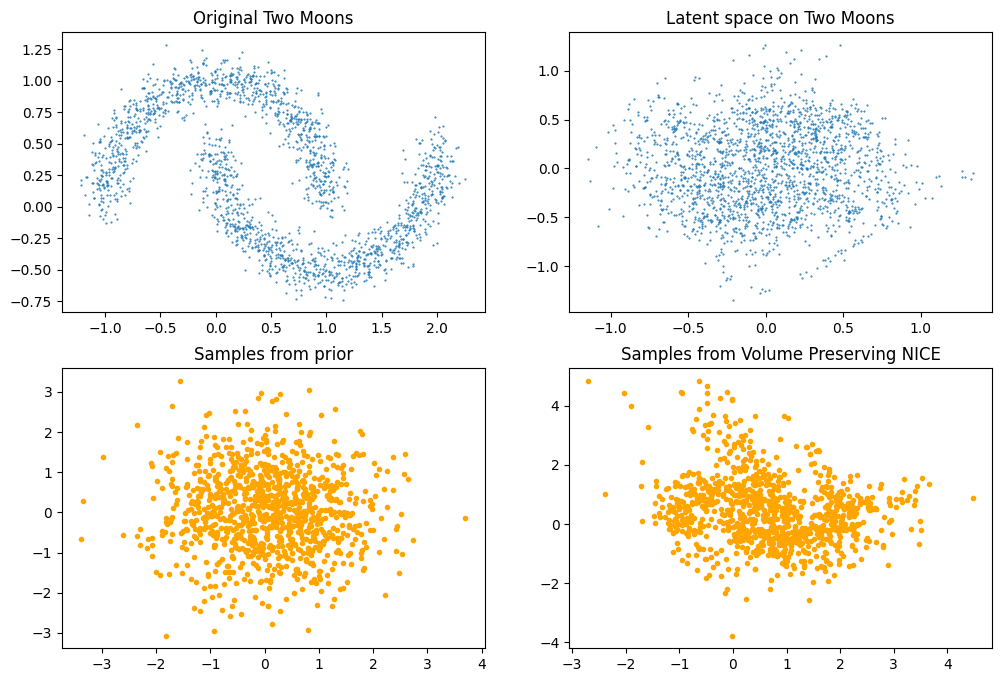

In [6]:
# -----------------------------
# Muestreo
# -----------------------------
torch.manual_seed(2)
with torch.no_grad():
    samples, prior_samples = model.generate_sample(1000)
    z_given_x = model.inference(X)

# -----------------------------
# Visualización
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

grid_size = 30
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
xx, yy = np.meshgrid(x, y)
points_plot = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)

with torch.no_grad():
    z_space = model.x_to_z(points_plot)
    x_space = model.z_to_x(points_plot)

# original dataset
axes[0, 0].plot(X[:, 0], X[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 0].set_title("Original Two Moons")

# original dataset mapped to z
axes[0, 1].plot(z_given_x[:, 0], z_given_x[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 1].set_title("Latent space on Two Moons")

# samples from p(z)
axes[1, 0].plot(prior_samples[:, 0], prior_samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 0].set_title("Samples from prior")

# samples from the flow
axes[1, 1].plot(samples[:, 0], samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 1].set_title("Samples from Volume Preserving NICE")

### Training a None Volume Preserving NICE

In [7]:
model = NICE(dim = 2, hidden_dim=128, num_coupling_layers = 6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 3000

for epoch in range(epochs):
    for x_tr, in dataloader:
        loss = -model.log_likelihood(x_tr).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {-loss.item():.4f}")

Epoch 100, Loss: -4292.9941
Epoch 200, Loss: -4059.4443
Epoch 300, Loss: -3785.2043
Epoch 400, Loss: -3492.5259
Epoch 500, Loss: -3311.6816
Epoch 600, Loss: -3134.7349
Epoch 700, Loss: -2949.7261
Epoch 800, Loss: -2814.2363
Epoch 900, Loss: -2701.2141
Epoch 1000, Loss: -2626.0378
Epoch 1100, Loss: -2572.1812
Epoch 1200, Loss: -2524.2046
Epoch 1300, Loss: -2488.0134
Epoch 1400, Loss: -2458.4053
Epoch 1500, Loss: -2434.7754
Epoch 1600, Loss: -2414.4551
Epoch 1700, Loss: -2397.8323
Epoch 1800, Loss: -2383.2527
Epoch 1900, Loss: -2369.5715
Epoch 2000, Loss: -2357.7266
Epoch 2100, Loss: -2338.1572
Epoch 2200, Loss: -2316.0347
Epoch 2300, Loss: -2305.6826
Epoch 2400, Loss: -2288.0757
Epoch 2500, Loss: -2273.5630
Epoch 2600, Loss: -2265.3462
Epoch 2700, Loss: -2259.2695
Epoch 2800, Loss: -2261.1799
Epoch 2900, Loss: -2250.5359
Epoch 3000, Loss: -2248.0669


Text(0.5, 1.0, 'Samples from Non Volume Preserving NICE')

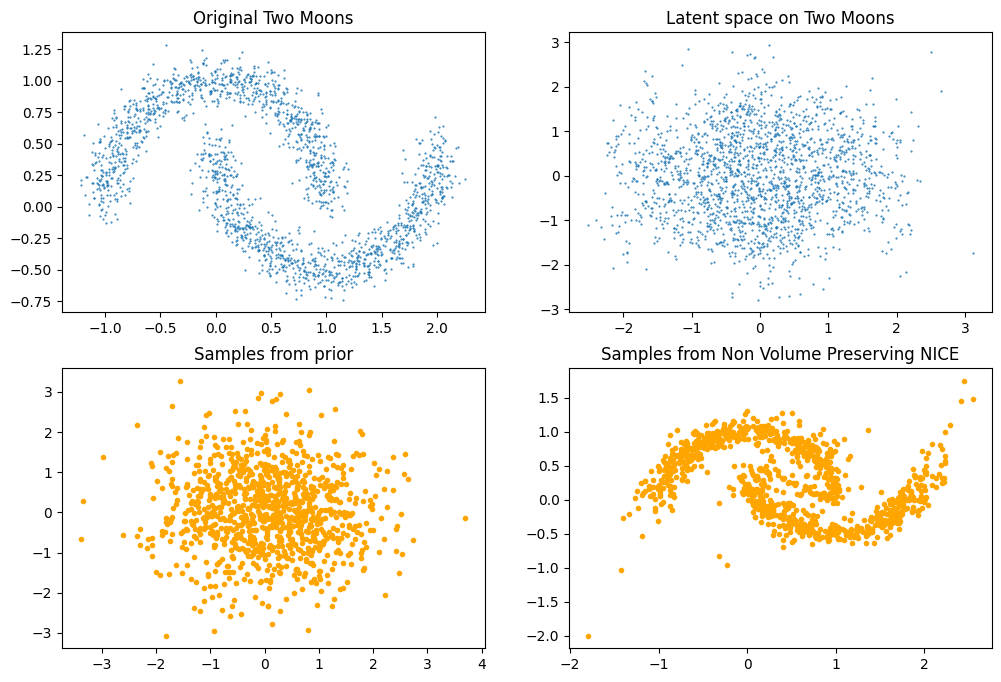

In [8]:
# -----------------------------
# Muestreo
# -----------------------------
torch.manual_seed(2)
with torch.no_grad():
    samples, prior_samples = model.generate_sample(1000)
    z_given_x = model.inference(X)

# -----------------------------
# Visualización
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

grid_size = 30
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
xx, yy = np.meshgrid(x, y)
points_plot = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)

with torch.no_grad():
    z_space = model.x_to_z(points_plot)
    x_space = model.z_to_x(points_plot)

# original dataset
axes[0, 0].plot(X[:, 0], X[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 0].set_title("Original Two Moons")

# original dataset mapped to z
axes[0, 1].plot(z_given_x[:, 0], z_given_x[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 1].set_title("Latent space on Two Moons")

# samples from p(z)
axes[1, 0].plot(prior_samples[:, 0], prior_samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 0].set_title("Samples from prior")

# samples from the flow
axes[1, 1].plot(samples[:, 0], samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 1].set_title("Samples from Non Volume Preserving NICE")

### Training a Real NVP

In [9]:
model = RealNVP(dim = 2, hidden_dim=128, num_coupling_layers = 6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 3000

for epoch in range(epochs):
    for x_tr, in dataloader:
        loss = -model.log_likelihood(x_tr).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {-loss.item():.4f}")

Epoch 100, Loss: -2728.9243
Epoch 200, Loss: -2472.4214
Epoch 300, Loss: -2351.9446
Epoch 400, Loss: -2261.7327
Epoch 500, Loss: -2210.2678
Epoch 600, Loss: -2184.7095
Epoch 700, Loss: -2150.0872
Epoch 800, Loss: -2132.2371
Epoch 900, Loss: -2131.0000
Epoch 1000, Loss: -2113.3899
Epoch 1100, Loss: -2112.7751
Epoch 1200, Loss: -2099.3135
Epoch 1300, Loss: -2105.1594
Epoch 1400, Loss: -2091.9551
Epoch 1500, Loss: -2088.9175
Epoch 1600, Loss: -2085.7092
Epoch 1700, Loss: -2086.4556
Epoch 1800, Loss: -2083.8352
Epoch 1900, Loss: -2087.9587
Epoch 2000, Loss: -2079.7021
Epoch 2100, Loss: -2081.5815
Epoch 2200, Loss: -2076.6211
Epoch 2300, Loss: -2069.3877
Epoch 2400, Loss: -2067.7991
Epoch 2500, Loss: -2068.2622
Epoch 2600, Loss: -2065.1790
Epoch 2700, Loss: -2068.7251
Epoch 2800, Loss: -2062.5635
Epoch 2900, Loss: -2060.2263
Epoch 3000, Loss: -2059.3230


Text(0.5, 1.0, 'Samples from Non Volume Preserving NICE')

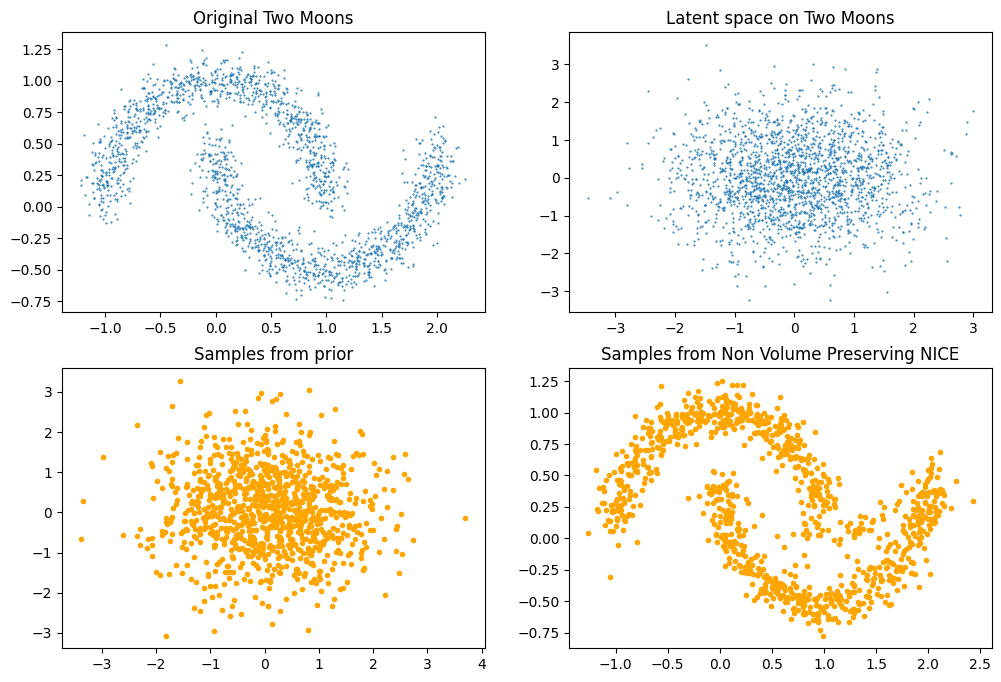

In [10]:
# -----------------------------
# Muestreo
# -----------------------------
torch.manual_seed(2)
with torch.no_grad():
    samples, prior_samples = model.generate_sample(1000)
    z_given_x = model.inference(X)

# -----------------------------
# Visualización
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

grid_size = 30
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
xx, yy = np.meshgrid(x, y)
points_plot = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)

with torch.no_grad():
    z_space = model.x_to_z(points_plot)
    x_space = model.z_to_x(points_plot)

# original dataset
axes[0, 0].plot(X[:, 0], X[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 0].set_title("Original Two Moons")

# original dataset mapped to z
axes[0, 1].plot(z_given_x[:, 0], z_given_x[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 1].set_title("Latent space on Two Moons")

# samples from p(z)
axes[1, 0].plot(prior_samples[:, 0], prior_samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 0].set_title("Samples from prior")

# samples from the flow
axes[1, 1].plot(samples[:, 0], samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 1].set_title("Samples from Non Volume Preserving NICE")

### How the spaced is deformed by the model?

In [11]:
model = RealNVP(dim = 2, hidden_dim=10, num_coupling_layers =10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1500

for epoch in range(epochs):
    for x_tr, in dataloader:
        loss = -model.log_likelihood(x_tr).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {-loss.item():.4f}")

Epoch 100, Loss: -3617.9451
Epoch 200, Loss: -3233.2368
Epoch 300, Loss: -2639.2603
Epoch 400, Loss: -2415.9021
Epoch 500, Loss: -2267.0730
Epoch 600, Loss: -2182.6528
Epoch 700, Loss: -2143.5579
Epoch 800, Loss: -2117.9612
Epoch 900, Loss: -2096.9980
Epoch 1000, Loss: -2078.8777
Epoch 1100, Loss: -2065.5015
Epoch 1200, Loss: -2054.1089
Epoch 1300, Loss: -2047.8533
Epoch 1400, Loss: -2042.9512
Epoch 1500, Loss: -2039.5542


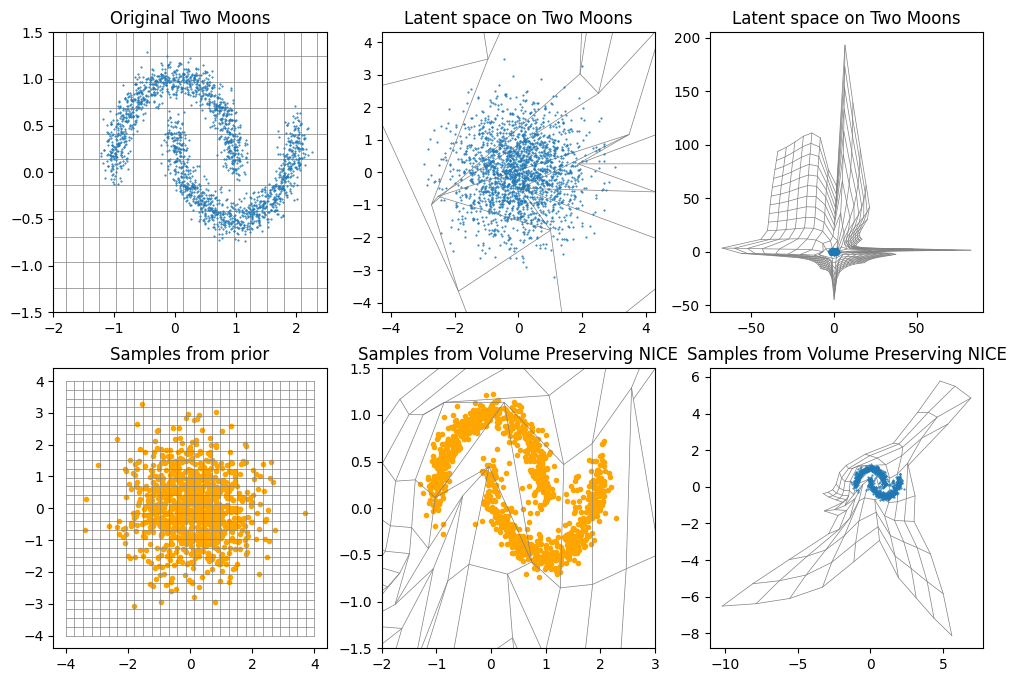

In [12]:
def plot_grid(points, ax, grid_size, color='gray', alpha=1.0, linewidth=0.5):
    # Convertir a numpy si es tensor
    points_np = points.detach().cpu().numpy() if hasattr(points, "detach") else points
    # Reshape a (grid_size, grid_size, 2)
    grid = points_np.reshape(grid_size, grid_size, 2)

    # Dibujar líneas horizontales
    for i in range(grid_size):
        ax.plot(grid[i, :, 0], grid[i, :, 1], color=color, alpha=alpha, linewidth=linewidth)
    # Dibujar líneas verticales
    for j in range(grid_size):
        ax.plot(grid[:, j, 0], grid[:, j, 1], color=color, alpha=alpha, linewidth=linewidth)

# -----------------------------
# Muestreo
# -----------------------------
torch.manual_seed(2)
with torch.no_grad():
    samples, prior_samples = model.generate_sample(1000)
    z_given_x = model.inference(X)

# -----------------------------
# Visualización
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8)) 

## define grid to plot deformation
grid_size_z_space = 20
x = np.linspace(-8, 8, grid_size_z_space)
y = np.linspace(-8, 8, grid_size_z_space)
xx, yy = np.meshgrid(x, y)
points_zspace = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)

grid_size_x_space = 10
x = np.linspace(-12, 12, grid_size_x_space)
y = np.linspace(-12, 12, grid_size_x_space)
xx, yy = np.meshgrid(x, y)
points_xspace = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)

gs_untransformed = 30
x = np.linspace(-4, 4, gs_untransformed)
y = np.linspace(-4, 4, gs_untransformed)
xx, yy = np.meshgrid(x, y)
points_plot_untransformed = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)

with torch.no_grad():
    z_space = model.x_to_z(points_zspace)
    x_space = model.z_to_x(points_xspace)

# Primer subplot
axes[0, 0].plot(X[:, 0], X[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 0].set_title("Original Two Moons")
plot_grid(points_plot_untransformed, axes[0, 0], grid_size=gs_untransformed)  # rejilla original sobre datos
axes[0, 0].set_xlim([-2,2.5])
axes[0, 0].set_ylim([-1.5,1.5])

# Segundo subplot
axes[0, 1].plot(z_given_x[:, 0], z_given_x[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 1].set_title("Latent space on Two Moons")
plot_grid(z_space, axes[0, 1], grid_size_z_space)  # rejilla deformada
axes[0, 1].set_xlim([-4.3,4.3])
axes[0, 1].set_ylim([-4.3,4.3])

# Tercer subplot
axes[0, 2].plot(z_given_x[:, 0], z_given_x[:, 1], 'o', markersize=0.5, zorder = 10)
axes[0, 2].set_title("Latent space on Two Moons")
plot_grid(z_space, axes[0, 2], grid_size_z_space)  # rejilla deformada

# cuarto subplot
axes[1, 0].plot(prior_samples[:, 0], prior_samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 0].set_title("Samples from prior")
plot_grid(points_plot_untransformed, axes[1, 0], gs_untransformed)  # rejilla original sobre datos
# axes[1, 0].set_xlim([-2,2.5])
# axes[1, 0].set_ylim([-1.5,1.5])

# quinto subplot
axes[1, 1].plot(samples[:, 0], samples[:, 1], 'o', markersize=3, color='orange')
axes[1, 1].set_title("Samples from Volume Preserving NICE")
plot_grid(x_space, axes[1, 1], grid_size_x_space)  # rejilla deformada
axes[1, 1].set_xlim([-2.,3])
axes[1, 1].set_ylim([-1.5,1.5])

# sexto subplot
axes[1, 2].plot(samples[:, 0], samples[:, 1], 'o', markersize=0.5, zorder = 10)
axes[1, 2].set_title("Samples from Volume Preserving NICE")
plot_grid(x_space, axes[1, 2], grid_size_x_space)  # rejilla deformada